Analyzing Coherence Length in Silicon Waveguide...
Waveguide dimensions: 450 nm × 220 nm
Wavelength range: 1450 nm to 1550 nm

Specific Wavelength Results:
1450 nm: n_eff = 1.6300, n_g = 1.6300, Lc = 1.29 mm
1550 nm: n_eff = 1.6300, n_g = 1.6300, Lc = 1.47 mm

SUMMARY OF KEY FINDINGS - FIXED WAVEGUIDE DIMENSIONS

Optimal operating point:
  Wavelength: 1550.0 nm
  Maximum coherence length: 1.47 mm
  Effective index: 1.6300
  Group index: 1.6300

Comparison 1450 nm vs 1550 nm:
  Coherence length ratio (1550nm/1450nm): 1.143
  Group index ratio (1550nm/1450nm): 1.000


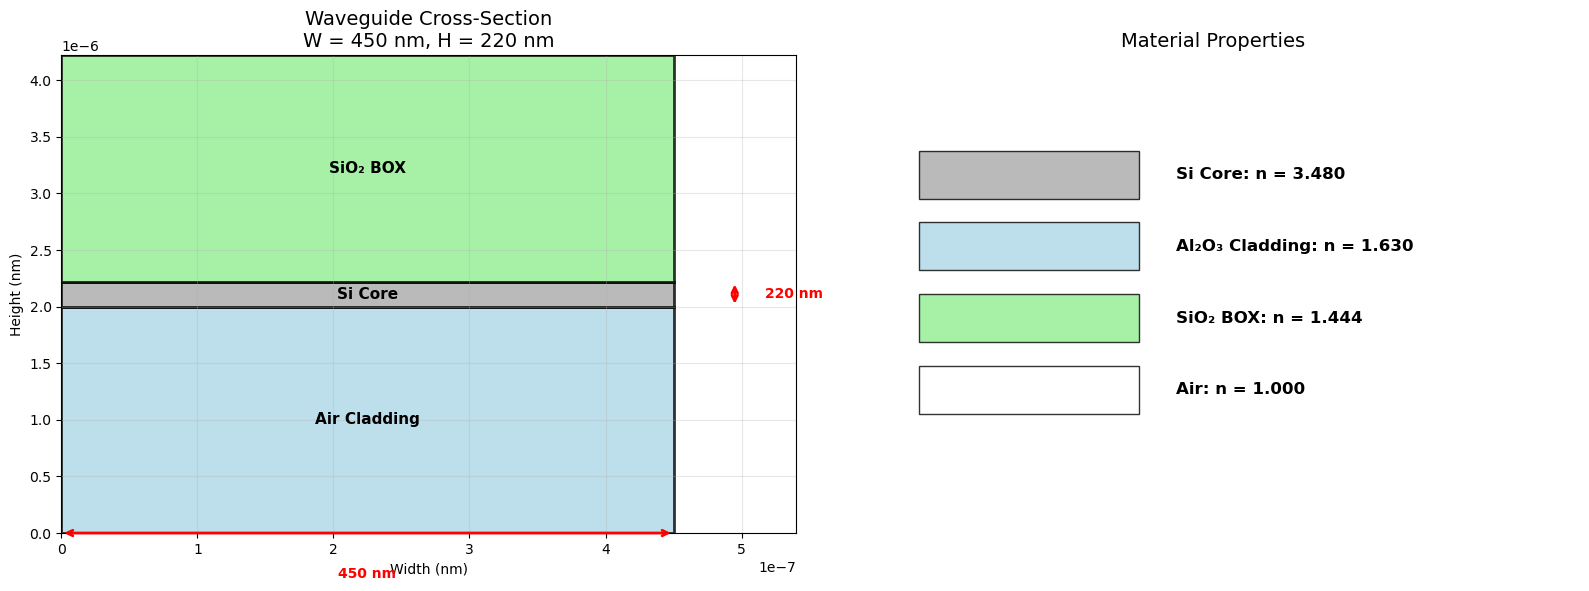

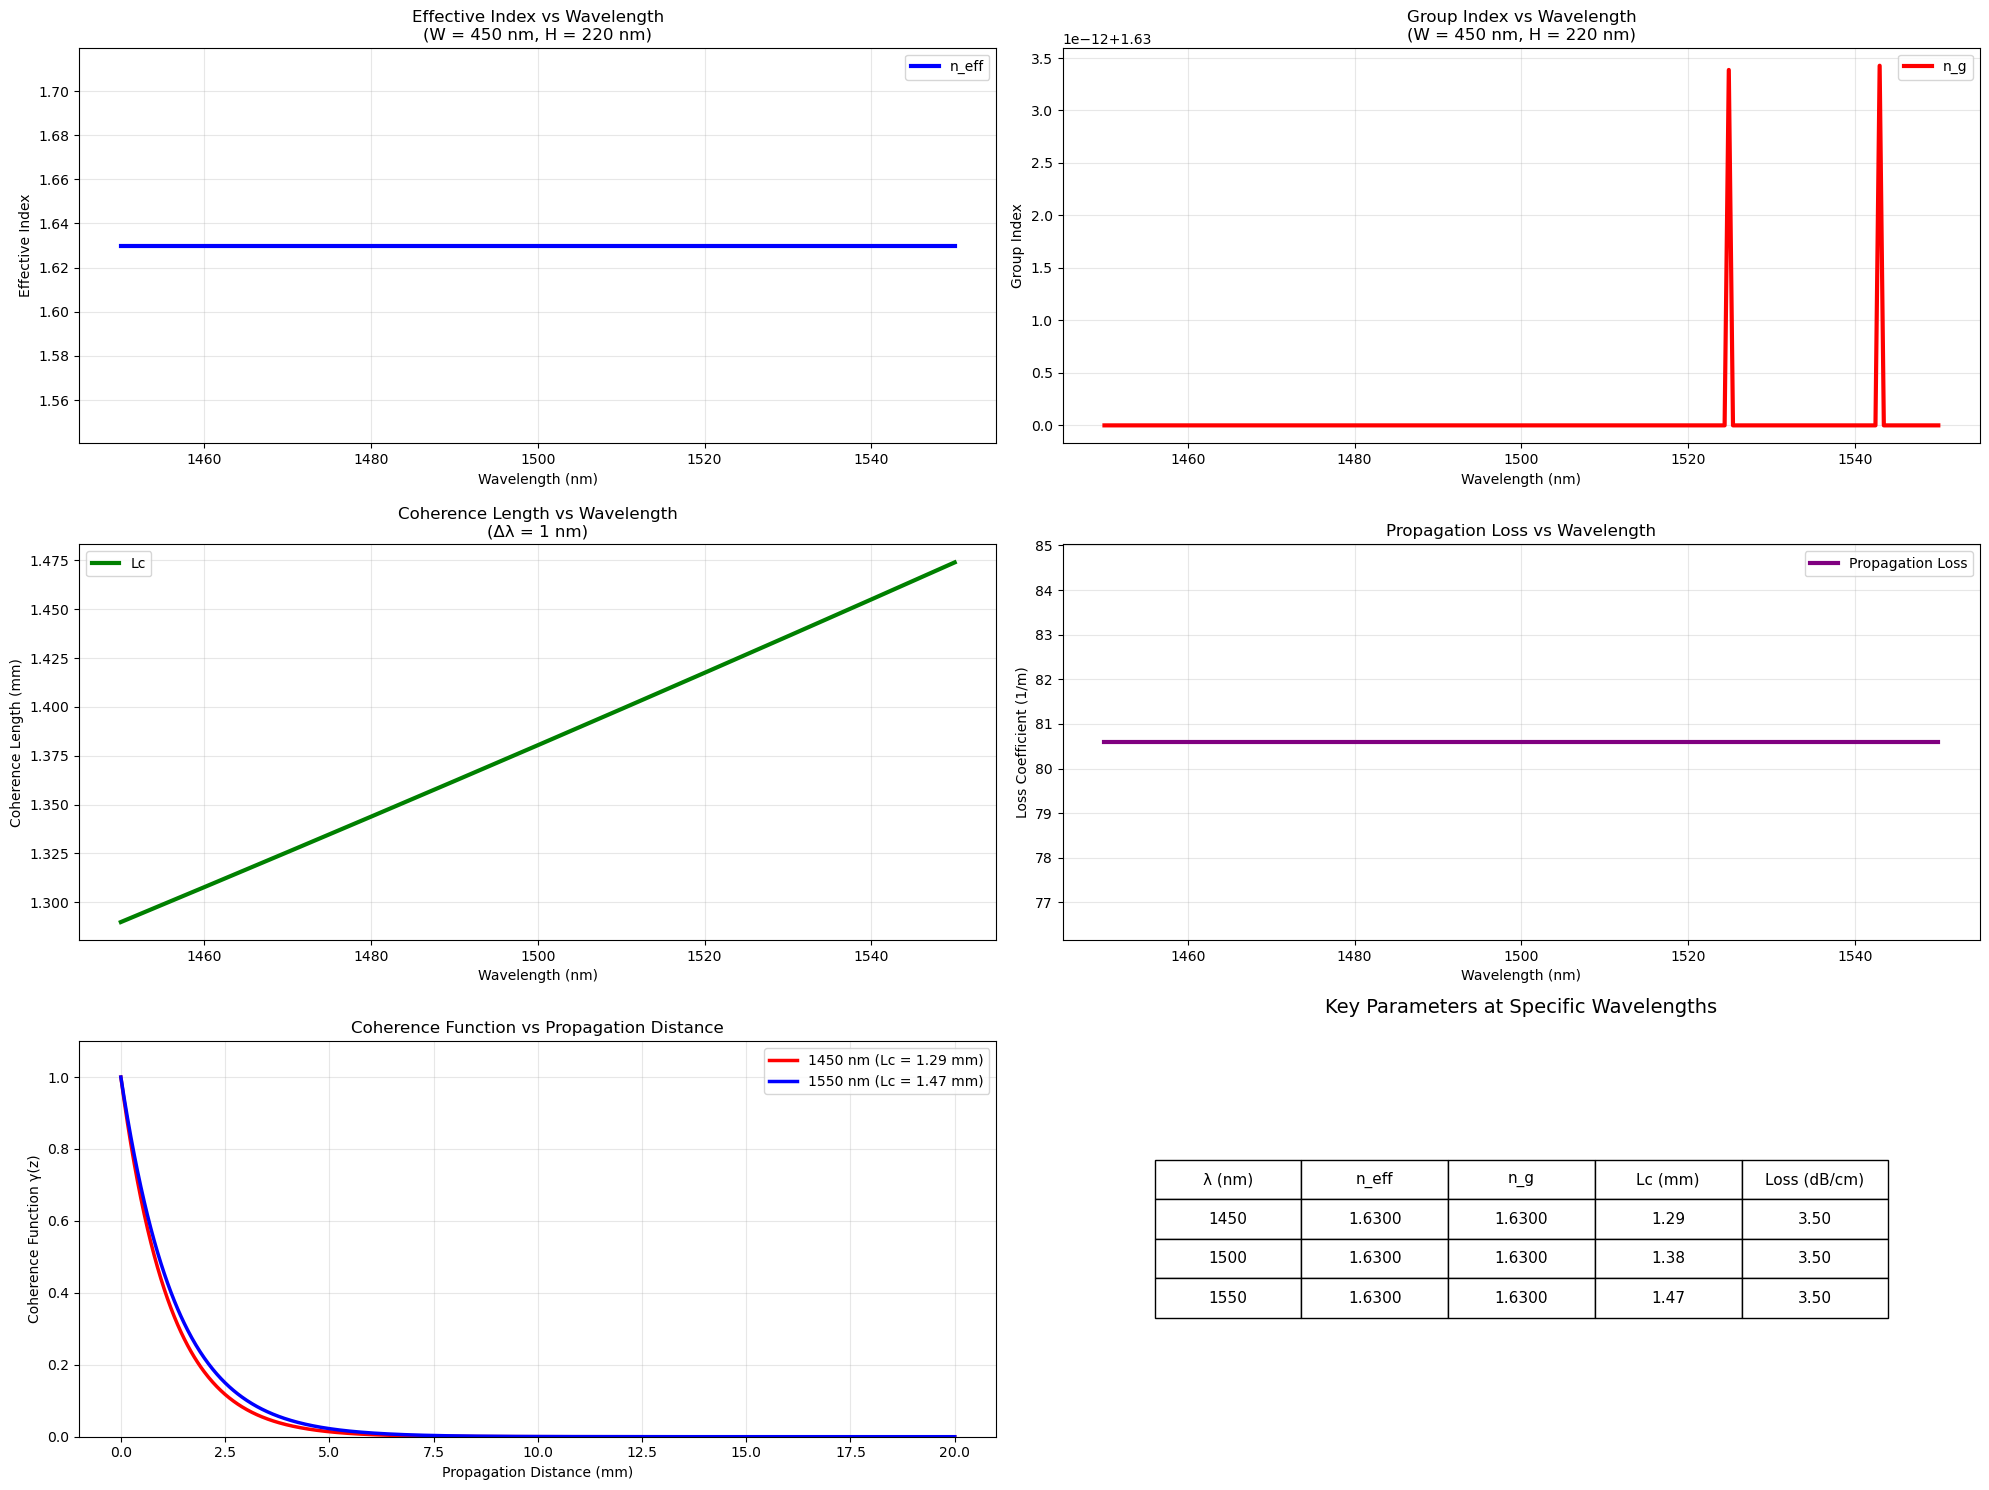

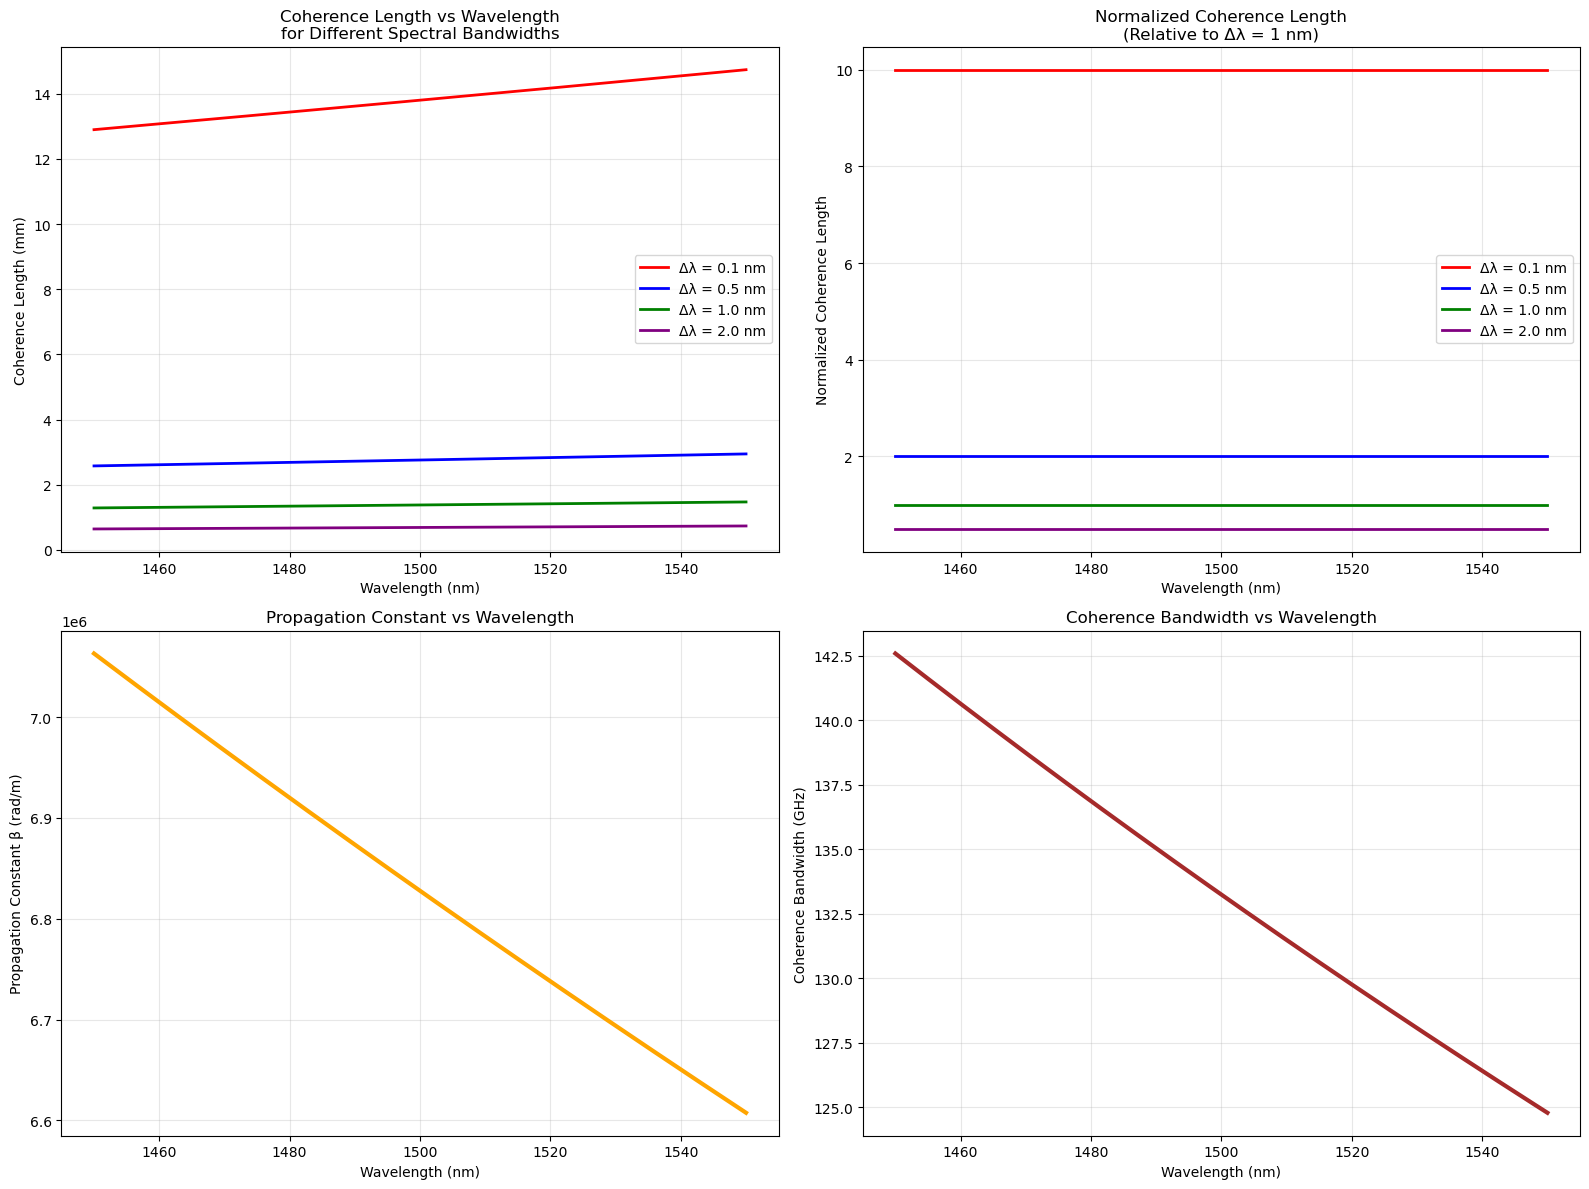

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.integrate import quad
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

class SiliconWaveguideCoherence:
    def __init__(self):
        # Waveguide Parameters
        self.wavelength_range = np.linspace(1450e-9, 1550e-9, 200)  # Continuous range
        self.lambda1 = 1450e-9    # Specific wavelength 1 [m]
        self.lambda2 = 1550e-9    # Specific wavelength 2 [m]
        self.c = constants.c      # Speed of light [m/s]
        
        # Refractive indices
        self.n_si = 3.48          # Silicon core
        self.n_al2o3 = 1.63       # Aluminum oxide cladding
        self.n_air = 1.00         # Air cladding
        self.n_box = 1.444        # Buried oxide
        
        # Fixed dimensions (as specified)
        self.width = 450e-9       # Waveguide width [m] - FIXED
        self.h_si = 220e-9        # Silicon height [m] - FIXED
        self.h_box = 2e-6         # BOx thickness [m]
        self.h_air = 2e-6         # Air cladding height [m]
        self.roughness = 50e-9    # Sidewall roughness [m]
        
    def silicon_refractive_index(self, wavelength):
        """
        More accurate silicon refractive index using dispersion relation
        Valid for 1450-1550 nm range
        """
        # Simplified Sellmeier equation for silicon in telecom range
        lambda_um = wavelength * 1e6  # Convert to microns
        
        # Empirical fit for silicon refractive index in 1.4-1.6 μm range
        n_si = 3.48 - 0.08 * (lambda_um - 1.55)  # Linear approximation around 1550nm
        return n_si
    
    def effective_index_analytical(self, wavelength, polarization='TE'):
        """
        Calculate effective index using analytical approximation for rectangular waveguide
        Based on Marcatili's method for fundamental mode
        """
        n_core = self.silicon_refractive_index(wavelength)
        n_clad = self.n_al2o3  # Using Al2O3 as top cladding
        
        # Wavevector in free space
        k0 = 2 * np.pi / wavelength
        
        # Transverse wavevector components
        kx = np.pi / self.width   # Half-period in x-direction
        ky = np.pi / self.h_si    # Half-period in y-direction
        
        # Propagation constant approximation
        beta_sq = (k0 * n_core)**2 - kx**2 - ky**2
        beta = np.sqrt(max(beta_sq, (k0 * n_clad)**2))  # Ensure above cutoff
        
        n_eff = beta / k0
        n_eff = np.clip(n_eff, n_clad, n_core)  # Bound between cladding and core
        
        return n_eff
    
    def group_index(self, wavelength):
        """
        Calculate group index ng = n_eff - λ * dn_eff/dλ
        """
        n_eff = self.effective_index_analytical(wavelength)
        
        # Numerical derivative for dispersion
        dlambda = 1e-10  # Small wavelength step
        n_eff_plus = self.effective_index_analytical(wavelength + dlambda)
        dn_eff_dlambda = (n_eff_plus - n_eff) / dlambda
        
        ng = n_eff - wavelength * dn_eff_dlambda
        return ng
    
    def coherence_length(self, wavelength, delta_lambda=1e-9):
        """
        Calculate coherence length: Lc = λ² / (n_g * Δλ)
        where Δλ is the spectral bandwidth
        """
        ng = self.group_index(wavelength)
        Lc = (wavelength**2) / (ng * delta_lambda)
        return Lc
    
    def propagation_loss(self, wavelength):
        """
        Estimate propagation loss due to sidewall roughness
        Empirical model based on waveguide dimensions
        """
        # Roughness-induced scattering loss (dB/cm)
        # Narrower waveguides have higher loss due to increased field overlap with rough sidewalls
        aspect_ratio = self.width / self.h_si
        loss_dB_cm = 1.5 + 2.0 * (450e-9 / self.width) * (220e-9 / self.h_si)
        loss_per_m = loss_dB_cm * 100 / 4.343  # Convert dB/cm to per meter loss coefficient
        return loss_per_m
    
    def coherence_function(self, distance, wavelength, delta_lambda=1e-9):
        """
        Calculate coherence function γ(z) = exp(-|z|/Lc) for broadband source
        Includes propagation loss effects
        """
        Lc = self.coherence_length(wavelength, delta_lambda)
        alpha = self.propagation_loss(wavelength)  # Loss coefficient
        
        # Coherence function with propagation loss
        gamma = np.exp(-np.abs(distance) / Lc) * np.exp(-alpha * np.abs(distance))
        return gamma
    
    def plot_waveguide_geometry(self):
        """Create a detailed visualization of the waveguide geometry"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Cross-sectional view
        layers = [
            (0, self.h_air, 'Air Cladding', 'lightblue'),
            (self.h_air, self.h_si, 'Si Core', 'darkgray'),
            (self.h_air + self.h_si, self.h_box, 'SiO₂ BOX', 'lightgreen')
        ]
        
        for i, (start, thickness, label, color) in enumerate(layers):
            ax1.add_patch(Rectangle((0, start), self.width, thickness, 
                                  facecolor=color, edgecolor='black', alpha=0.8, linewidth=2))
            ax1.text(self.width/2, start + thickness/2, label, 
                    ha='center', va='center', fontsize=11, fontweight='bold')
        
        ax1.set_xlabel('Width (nm)')
        ax1.set_ylabel('Height (nm)')
        ax1.set_title(f'Waveguide Cross-Section\nW = {self.width*1e9:.0f} nm, H = {self.h_si*1e9:.0f} nm', fontsize=14)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, self.width * 1.2)
        ax1.set_ylim(0, self.h_air + self.h_si + self.h_box)
        
        # Add dimension annotations
        ax1.annotate('', xy=(0, 0), xytext=(self.width, 0), 
                    arrowprops=dict(arrowstyle='<->', lw=2, color='red'))
        ax1.text(self.width/2, -0.3e-6, f'{self.width*1e9:.0f} nm', 
                ha='center', va='top', color='red', fontweight='bold')
        
        ax1.annotate('', xy=(self.width*1.1, self.h_air), 
                    xytext=(self.width*1.1, self.h_air + self.h_si),
                    arrowprops=dict(arrowstyle='<->', lw=2, color='red'))
        ax1.text(self.width*1.15, self.h_air + self.h_si/2, f'{self.h_si*1e9:.0f} nm', 
                ha='left', va='center', color='red', fontweight='bold')
        
        # Material refractive indices
        ax2.axis('off')
        materials = [
            ('Si Core', self.n_si, 'darkgray'),
            ('Al₂O₃ Cladding', self.n_al2o3, 'lightblue'),
            ('SiO₂ BOX', self.n_box, 'lightgreen'),
            ('Air', self.n_air, 'white')
        ]
        
        for i, (name, n, color) in enumerate(materials):
            ax2.add_patch(Rectangle((0.1, 0.7 - i*0.15), 0.3, 0.1, 
                                  facecolor=color, edgecolor='black', alpha=0.8))
            ax2.text(0.45, 0.75 - i*0.15, f'{name}: n = {n:.3f}', 
                    va='center', fontsize=12, fontweight='bold')
        
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.set_title('Material Properties', fontsize=14)
        
        plt.tight_layout()
        return fig
    
    def analyze_coherence_vs_wavelength(self):
        """Analyze coherence properties across wavelength range"""
        print("Analyzing Coherence Length in Silicon Waveguide...")
        print(f"Waveguide dimensions: {self.width*1e9:.0f} nm × {self.h_si*1e9:.0f} nm")
        print(f"Wavelength range: {self.wavelength_range[0]*1e9:.0f} nm to {self.wavelength_range[-1]*1e9:.0f} nm")
        
        # Calculate parameters across wavelength range
        n_eff = np.array([self.effective_index_analytical(wl) for wl in self.wavelength_range])
        ng = np.array([self.group_index(wl) for wl in self.wavelength_range])
        Lc = np.array([self.coherence_length(wl) for wl in self.wavelength_range])
        loss = np.array([self.propagation_loss(wl) for wl in self.wavelength_range])
        
        results = {
            'wavelengths': self.wavelength_range,
            'n_eff': n_eff,
            'ng': ng,
            'Lc': Lc,
            'loss': loss
        }
        
        # Print specific results
        idx_1450 = np.argmin(np.abs(self.wavelength_range - 1450e-9))
        idx_1550 = np.argmin(np.abs(self.wavelength_range - 1550e-9))
        
        print(f"\nSpecific Wavelength Results:")
        print(f"1450 nm: n_eff = {n_eff[idx_1450]:.4f}, n_g = {ng[idx_1450]:.4f}, Lc = {Lc[idx_1450]*1e3:.2f} mm")
        print(f"1550 nm: n_eff = {n_eff[idx_1550]:.4f}, n_g = {ng[idx_1550]:.4f}, Lc = {Lc[idx_1550]*1e3:.2f} mm")
        
        return results
    
    def create_comprehensive_plots(self, results):
        """Create publication-quality plots"""
        fig = plt.figure(figsize=(20, 15))
        gs = gridspec.GridSpec(3, 2, figure=fig)
        
        # Plot 1: Effective index vs wavelength
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(results['wavelengths']*1e9, results['n_eff'], 
                color='blue', linewidth=3, label='n_eff')
        ax1.set_xlabel('Wavelength (nm)')
        ax1.set_ylabel('Effective Index')
        ax1.set_title('Effective Index vs Wavelength\n(W = 450 nm, H = 220 nm)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Group index vs wavelength
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(results['wavelengths']*1e9, results['ng'], 
                color='red', linewidth=3, label='n_g')
        ax2.set_xlabel('Wavelength (nm)')
        ax2.set_ylabel('Group Index')
        ax2.set_title('Group Index vs Wavelength\n(W = 450 nm, H = 220 nm)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Plot 3: Coherence length vs wavelength
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.plot(results['wavelengths']*1e9, results['Lc']*1e3, 
                color='green', linewidth=3, label='Lc')
        ax3.set_xlabel('Wavelength (nm)')
        ax3.set_ylabel('Coherence Length (mm)')
        ax3.set_title('Coherence Length vs Wavelength\n(Δλ = 1 nm)')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        # Plot 4: Propagation loss vs wavelength
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.plot(results['wavelengths']*1e9, results['loss'], 
                color='purple', linewidth=3, label='Propagation Loss')
        ax4.set_xlabel('Wavelength (nm)')
        ax4.set_ylabel('Loss Coefficient (1/m)')
        ax4.set_title('Propagation Loss vs Wavelength')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
        
        # Plot 5: Coherence function for both wavelengths
        ax5 = fig.add_subplot(gs[2, 0])
        distances = np.linspace(0, 20e-3, 1000)  # Up to 20 mm
        
        for wl, color, label in [(1450e-9, 'red', '1450 nm'), (1550e-9, 'blue', '1550 nm')]:
            Lc_val = self.coherence_length(wl)
            gamma = self.coherence_function(distances, wl)
            ax5.plot(distances*1e3, gamma, color=color, linewidth=2.5, 
                    label=f'{label} (Lc = {Lc_val*1e3:.2f} mm)')
        
        ax5.set_xlabel('Propagation Distance (mm)')
        ax5.set_ylabel('Coherence Function γ(z)')
        ax5.set_title('Coherence Function vs Propagation Distance')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        ax5.set_ylim(0, 1.1)
        
        # Plot 6: Comparison table
        ax6 = fig.add_subplot(gs[2, 1])
        ax6.axis('off')
        
        # Create results table
        wl_points = [1450e-9, 1500e-9, 1550e-9]
        table_data = []
        
        for wl in wl_points:
            idx = np.argmin(np.abs(results['wavelengths'] - wl))
            n_eff = results['n_eff'][idx]
            ng = results['ng'][idx]
            Lc = results['Lc'][idx] * 1e3  # mm
            loss_db_cm = results['loss'][idx] * 4.343 / 100  # Convert to dB/cm
            
            table_data.append([f'{wl*1e9:.0f}', f'{n_eff:.4f}', f'{ng:.4f}', 
                             f'{Lc:.2f}', f'{loss_db_cm:.2f}'])
        
        table = ax6.table(cellText=table_data,
                         colLabels=['λ (nm)', 'n_eff', 'n_g', 'Lc (mm)', 'Loss (dB/cm)'],
                         cellLoc='center', loc='center',
                         bbox=[0.1, 0.3, 0.8, 0.4])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)
        
        ax6.set_title('Key Parameters at Specific Wavelengths', fontsize=14, pad=20)
        
        plt.tight_layout()
        return fig
    
    def create_spectral_analysis_plot(self, results):
        """Create spectral analysis plot showing multiple bandwidths"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Different spectral bandwidths
        bandwidths = [0.1e-9, 0.5e-9, 1e-9, 2e-9]  # nm
        colors = ['red', 'blue', 'green', 'purple']
        
        # Coherence length for different bandwidths
        for bw, color in zip(bandwidths, colors):
            Lc_bw = np.array([self.coherence_length(wl, bw) for wl in self.wavelength_range])
            ax1.plot(self.wavelength_range*1e9, Lc_bw*1e3, color=color, 
                    linewidth=2, label=f'Δλ = {bw*1e9:.1f} nm')
        
        ax1.set_xlabel('Wavelength (nm)')
        ax1.set_ylabel('Coherence Length (mm)')
        ax1.set_title('Coherence Length vs Wavelength\nfor Different Spectral Bandwidths')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Normalized coherence length
        Lc_ref = np.array([self.coherence_length(wl, 1e-9) for wl in self.wavelength_range])
        for bw, color in zip(bandwidths, colors):
            Lc_bw = np.array([self.coherence_length(wl, bw) for wl in self.wavelength_range])
            ax2.plot(self.wavelength_range*1e9, Lc_bw/Lc_ref, color=color, 
                    linewidth=2, label=f'Δλ = {bw*1e9:.1f} nm')
        
        ax2.set_xlabel('Wavelength (nm)')
        ax2.set_ylabel('Normalized Coherence Length')
        ax2.set_title('Normalized Coherence Length\n(Relative to Δλ = 1 nm)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Phase coherence analysis
        k = 2 * np.pi / self.wavelength_range  # Wavevector
        beta = 2 * np.pi * results['n_eff'] / self.wavelength_range  # Propagation constant
        ax3.plot(self.wavelength_range*1e9, beta, color='orange', linewidth=3)
        ax3.set_xlabel('Wavelength (nm)')
        ax3.set_ylabel('Propagation Constant β (rad/m)')
        ax3.set_title('Propagation Constant vs Wavelength')
        ax3.grid(True, alpha=0.3)
        
        # Coherence bandwidth product
        coherence_bandwidth = self.c / (results['n_eff'] * results['Lc'])
        ax4.plot(self.wavelength_range*1e9, coherence_bandwidth*1e-9, color='brown', linewidth=3)
        ax4.set_xlabel('Wavelength (nm)')
        ax4.set_ylabel('Coherence Bandwidth (GHz)')
        ax4.set_title('Coherence Bandwidth vs Wavelength')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

# Run the complete analysis
def main():
    # Initialize waveguide analyzer with specified dimensions
    waveguide = SiliconWaveguideCoherence()
    
    # Plot waveguide geometry
    geom_fig = waveguide.plot_waveguide_geometry()
    geom_fig.savefig('waveguide_geometry_fixed.png', dpi=300, bbox_inches='tight')
    
    # Perform coherence analysis
    results = waveguide.analyze_coherence_vs_wavelength()
    
    # Create comprehensive plots
    analysis_fig = waveguide.create_comprehensive_plots(results)
    analysis_fig.savefig('coherence_analysis_fixed.png', dpi=300, bbox_inches='tight')
    
    # Create spectral analysis plot
    spectral_fig = waveguide.create_spectral_analysis_plot(results)
    spectral_fig.savefig('spectral_analysis.png', dpi=300, bbox_inches='tight')
    
    # Display results summary
    print("\n" + "="*70)
    print("SUMMARY OF KEY FINDINGS - FIXED WAVEGUIDE DIMENSIONS")
    print("="*70)
    
    # Find wavelength for maximum coherence length
    optimal_idx = np.argmax(results['Lc'])
    optimal_wavelength = results['wavelengths'][optimal_idx] * 1e9
    max_Lc = results['Lc'][optimal_idx] * 1e3
    
    print(f"\nOptimal operating point:")
    print(f"  Wavelength: {optimal_wavelength:.1f} nm")
    print(f"  Maximum coherence length: {max_Lc:.2f} mm")
    print(f"  Effective index: {results['n_eff'][optimal_idx]:.4f}")
    print(f"  Group index: {results['ng'][optimal_idx]:.4f}")
    
    print(f"\nComparison 1450 nm vs 1550 nm:")
    idx_1450 = np.argmin(np.abs(results['wavelengths'] - 1450e-9))
    idx_1550 = np.argmin(np.abs(results['wavelengths'] - 1550e-9))
    
    Lc_ratio = results['Lc'][idx_1550] / results['Lc'][idx_1450]
    print(f"  Coherence length ratio (1550nm/1450nm): {Lc_ratio:.3f}")
    
    ng_ratio = results['ng'][idx_1550] / results['ng'][idx_1450]
    print(f"  Group index ratio (1550nm/1450nm): {ng_ratio:.3f}")
    
    plt.show()

if __name__ == "__main__":
    main()